### Load modules and define function to load data

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

veg_type_name = {0: "Combined", 1: "Grassland", 2: "Shrubsland", 3: "Forest"}

def generate_train_datasets(veg_type=0, subset_perc=0.15, test_size=0.25):
    # 1.- Load
    df = pd.read_csv("fmc_s2_reflectances.csv")
    
    df['ndvi'] = ((df.nbart_nir_1-df.nbart_red)/(df.nbart_nir_1+df.nbart_red))
    df['ndii'] = ((df.nbart_nir_1-df.nbart_swir_2)/(df.nbart_nir_1+df.nbart_swir_2))
    
    # 2.- Shuffle
    df = df.sample(frac=1)

    # 3.- Filter veg_type
    if veg_type != 0:
        df = df[df['veg_type']==veg_type]

    # 4.- Subset
    df = df.sample(frac=subset_perc)

    # 5.- Split train/val
    return train_test_split(df, test_size=test_size)

### Linear regression test

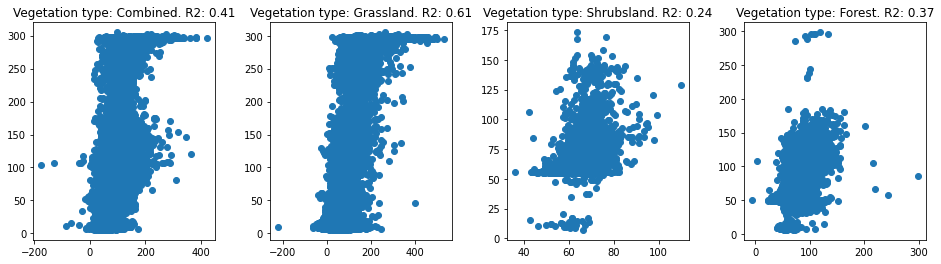

In [3]:
fig, axs = plt.subplots(1,4, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)
axs = axs.ravel()

for veg_type in [0,1,2,3]:
    train, test = generate_train_datasets(veg_type)
    lr = LinearRegression()
    lr.fit(train[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], train['fmc_mean'])
    y_hat = lr.predict(test[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']])
    axs[veg_type].scatter(y_hat, test['fmc_mean'].values)
    score = lr.score(test[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])
    axs[veg_type].set_title(f"Vegetation type: {veg_type_name[veg_type]}. R2: {score:.2f}")

### Random Forest test

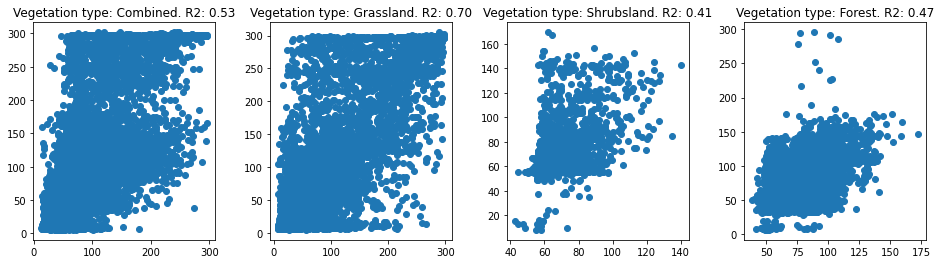

In [4]:
fig, axs = plt.subplots(1,4, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)
axs = axs.ravel()

for veg_type in [0,1,2,3]:
    rf = RandomForestRegressor(n_estimators=25, max_depth=10, n_jobs=8)
    train, test = generate_train_datasets(veg_type)
    rf.fit(train[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], train['fmc_mean'])
    y_hat = rf.predict(test[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']])
    axs[veg_type].scatter(y_hat, test['fmc_mean'].values)
    score = rf.score(test[['ndvi','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])
    axs[veg_type].set_title(f"Vegetation type: {veg_type_name[veg_type]}. R2: {score:.2f}")

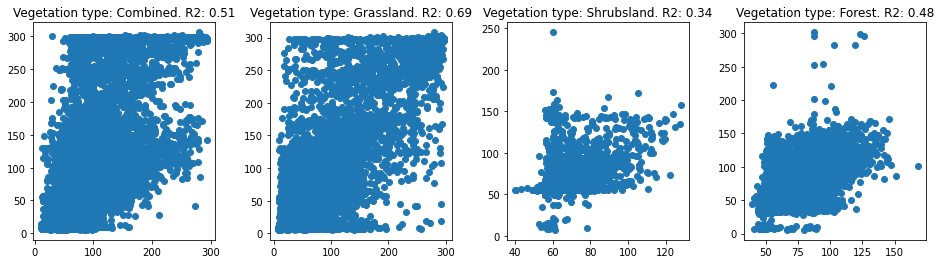

In [26]:
fig, axs = plt.subplots(1,4, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)
axs = axs.ravel()

for veg_type in [0,1,2,3]:
    rf = RandomForestRegressor(n_estimators=25, max_depth=10, n_jobs=8)
    train, test = generate_train_datasets(veg_type)
    rf.fit(train[['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], train['fmc_mean'])
    y_hat = rf.predict(test[['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']])
    axs[veg_type].scatter(y_hat, test['fmc_mean'].values)
    score = rf.score(test[['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])
    axs[veg_type].set_title(f"Vegetation type: {veg_type_name[veg_type]}. R2: {score:.2f}")

### Feature Importance

0.5539623262983839

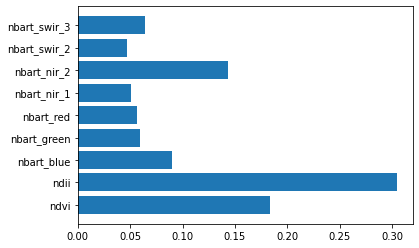

In [16]:
rf = RandomForestRegressor(n_estimators=50, max_depth=50, n_jobs=8)
train, test = generate_train_datasets(0)
predictors = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
rf.fit(train[predictors], train['fmc_mean'])

plt.barh(predictors, rf.feature_importances_)

rf.score(test[['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])

In [17]:
rf.predict(test[predictors])

test[predictors].columns

Index(['ndvi', 'ndii', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1',
       'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3'],
      dtype='object')

In [18]:
import xarray as xr

ds = xr.open_dataset("Namadgi_ref.nc")

ds['ndvi'] = ((ds.nbart_nir_1-ds.nbart_red)/(ds.nbart_nir_1+ds.nbart_red))
ds['ndii'] = ((ds.nbart_nir_1-ds.nbart_swir_2)/(ds.nbart_nir_1+ds.nbart_swir_2))

refl = ds[['ndvi','ndii','nbart_red','nbart_green','nbart_blue','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']].to_array().values
refl_rf = refl.reshape((9,-1)).swapaxes(0,1)
refl_rf.shape

(1276990, 9)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 29.3 µs
(1276990, 9) (9, 1222, 1045)
(1222, 1045)


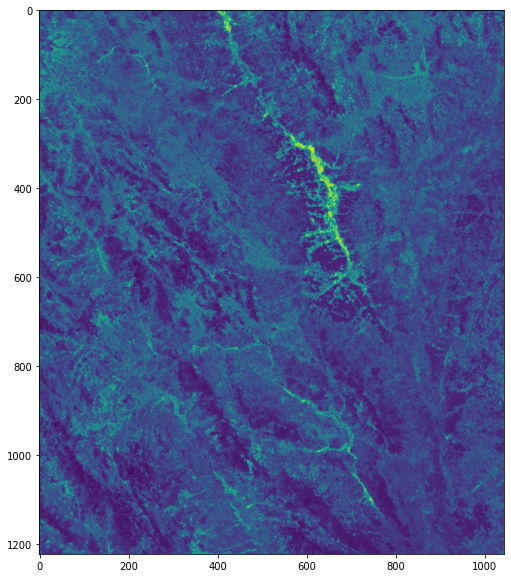

In [19]:
%time 

rf_fmc = rf.predict(refl_rf)
fmc = rf_fmc.reshape(refl.shape[1:])

plt.figure(figsize=(10,10))
plt.imshow(fmc)

### Saving model

In [ ]:
import pickle

with open('rf_ndvi.pickle', 'wb') as handle:
    pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)
#clf2 = pickle.loads(s)
#clf2.predict(X[0:1])

### Removing green band

0.5237800788377776

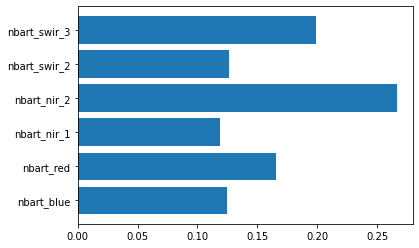

In [11]:
rf = RandomForestRegressor(n_estimators=50, max_depth=50, n_jobs=8)
train, test = generate_train_datasets(0)
predictors = ['nbart_blue','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
rf.fit(train[predictors], train['fmc_mean'])

plt.barh(predictors, rf.feature_importances_)

rf.score(test[['nbart_blue','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])

### RF configuration R2 comparison

In [12]:
for veg_type in [0,1,2,3]:
    print(f"------- Vegetation type: {veg_type_name[veg_type]} --------")
    for n_estimators in [10,25,50]:
        for max_depth in [5,10,25,50]:
            rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=8)
            train, test = generate_train_datasets(veg_type)
            rf.fit(train[['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], train['fmc_mean'])
            score = rf.score(test[['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']], test['fmc_mean'])
            print(f"        Estimators: {n_estimators} -- Depth: {max_depth:02} -- R2: {score:.2f}")

------- Vegetation type: Combined --------
        Estimators: 10 -- Depth: 05 -- R2: 0.40
        Estimators: 10 -- Depth: 10 -- R2: 0.52
        Estimators: 10 -- Depth: 25 -- R2: 0.52
        Estimators: 10 -- Depth: 50 -- R2: 0.51
        Estimators: 25 -- Depth: 05 -- R2: 0.42
        Estimators: 25 -- Depth: 10 -- R2: 0.52
        Estimators: 25 -- Depth: 25 -- R2: 0.54
        Estimators: 25 -- Depth: 50 -- R2: 0.54
        Estimators: 50 -- Depth: 05 -- R2: 0.42
        Estimators: 50 -- Depth: 10 -- R2: 0.52
        Estimators: 50 -- Depth: 25 -- R2: 0.55
        Estimators: 50 -- Depth: 50 -- R2: 0.56
------- Vegetation type: Grassland --------
        Estimators: 10 -- Depth: 05 -- R2: 0.58
        Estimators: 10 -- Depth: 10 -- R2: 0.69
        Estimators: 10 -- Depth: 25 -- R2: 0.71
        Estimators: 10 -- Depth: 50 -- R2: 0.69
        Estimators: 25 -- Depth: 05 -- R2: 0.58
        Estimators: 25 -- Depth: 10 -- R2: 0.70
        Estimators: 25 -- Depth: 25 -- R2: 0.72
 